First check that you have pytorch installed, instructions are here: https://pytorch.org/get-started/locally/ , prefferably do it with anaconda if you can, I think that will lead to less problems down the road if we use other libraries.

If cuda toolkit isnt available and you have an nvidia gpu try to get that too (it might be contained within anaconda pytorch package): https://docs.nvidia.com/cuda/cuda-installation-guide-microsoft-windows/index.html

Also note that because the dataset is large I added it to the .gitignore, you should download it from here : https://www.kaggle.com/c/cassava-leaf-disease-classification/data, and extract it into the data/ folder of the project


In [1]:
import pickle
import torch
import os 
import cv2
import json
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline

from torch import FloatTensor, LongTensor, nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

use_cuda = True
if not torch.cuda.is_available():
    print("if you have an nvidia gpu get the cuda core package")
    device = torch.device('cpu')
else:
    print("cuda is available")
    device = torch.device('cuda:0')

cuda is available


Scaling down the images and saving them to an object

In [2]:
#setting the path to the directory containing the pics
path = './data/train_images'
scaling = (80,80) #scale the images down to this resolution
output_images = './data/train_scaled'
output_filenames = './data/train_scaled_index'

if not os.path.isfile('{}.npy'.format(output_images)):
    training_data = []
    filenames = []
    for img in os.listdir(path):
        pic = cv2.imread(os.path.join(path,img))
        pic = cv2.cvtColor(pic,cv2.COLOR_BGR2RGB)
        pic = cv2.resize(pic,scaling)
        training_data.append(pic)
        filenames.append(img)

    #converting the list to numpy array and saving it to a file using #numpy.save
    np.save(output_images,np.array(training_data))
    np.save(output_filenames,np.array(filenames))

    

Load mapping dictionary and the image dataset with the .csv of the labels

In [3]:
with open('./data/train.csv', newline='') as csvfile:
    labelled_dataset = dict(csv.reader(csvfile))
#print(labelled_dataset)
with open('./data/label_num_to_disease_map.json') as f:
    mapping_dict = json.load(f)


#loading the saved file once again
images = np.load('{}.npy'.format(output_images))
filenames = np.load('{}.npy'.format(output_filenames))

tensor_x = torch.Tensor(images) # transform to torch tensor
tensor_x = tensor_x.permute(0, 3, 1, 2)
tensor_y = torch.LongTensor([int(labelled_dataset[filename]) for filename in filenames])
full_dataset = TensorDataset(tensor_x,tensor_y) 

print(len(full_dataset))
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset,[int(len(tensor_x)*0.75+1), int(len(tensor_x)*0.25)],generator=torch.Generator().manual_seed(1337))
# train size is 75% test size is 25%
test_dataloader = DataLoader(test_dataset)
train_dataloader = DataLoader(train_dataset) 


def show_image(index):  
    plt.imshow(images[index].reshape(80,80,3)) # set the correct resolution here
    print(filenames[index])

21397


Show an image from the dataset

1000910826.jpg
torch.Size([21397, 3, 80, 80])
torch.Size([21397])
21397


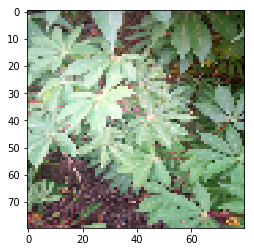

In [4]:
show_image(6)
print(tensor_x.shape)
print(tensor_y.shape)
print(int(len(tensor_x)*0.75+1)+int(len(tensor_x)*0.25))

Using resnet 18 pretrained pytorch model

In [6]:
net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
net = net.cuda() if device else net

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)


def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 128)
net.fc = net.fc.cuda() if use_cuda else net.fc


Using cache found in C:\Users\Moji podatki/.cache\torch\hub\pytorch_vision_v0.6.0


Do evaluation, (still have to try out parameters specified in paper, find out which are useful) code: https://www.pluralsight.com/guides/introduction-to-resnet

In [7]:
n_epochs = 5
print_every = int(len(tensor_x)*0.1) # print upon completion of every 10% of the dataset
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % print_every == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/5], Step [0/16048], Loss: 5.2050
Epoch [1/5], Step [2139/16048], Loss: 4.5222
Epoch [1/5], Step [4278/16048], Loss: 4.6987
Epoch [1/5], Step [6417/16048], Loss: 1.6130
Epoch [1/5], Step [8556/16048], Loss: 1.4063
Epoch [1/5], Step [10695/16048], Loss: 5.4261
Epoch [1/5], Step [12834/16048], Loss: 4.4243
Epoch [1/5], Step [14973/16048], Loss: 5.3821

train-loss: 2.9606, train-acc: 57.5336
validation loss: 3.0974, validation acc: 62.6472

Improvement-Detected, save-model
Epoch 2

Epoch [2/5], Step [0/16048], Loss: 4.3660
Epoch [2/5], Step [2139/16048], Loss: 4.1237
Epoch [2/5], Step [4278/16048], Loss: 4.2075
Epoch [2/5], Step [6417/16048], Loss: 0.9870
Epoch [2/5], Step [8556/16048], Loss: 0.9180
Epoch [2/5], Step [10695/16048], Loss: 5.0356
Epoch [2/5], Step [12834/16048], Loss: 3.9370
Epoch [2/5], Step [14973/16048], Loss: 4.9647

train-loss: 2.6358, train-acc: 61.1104
validation loss: 2.8443, validation acc: 62.6472

Improvement-Detected, save-model
Epoch 3

Epoch [

With 5 epochs it took around 15 mins on my machine, with cuda cores

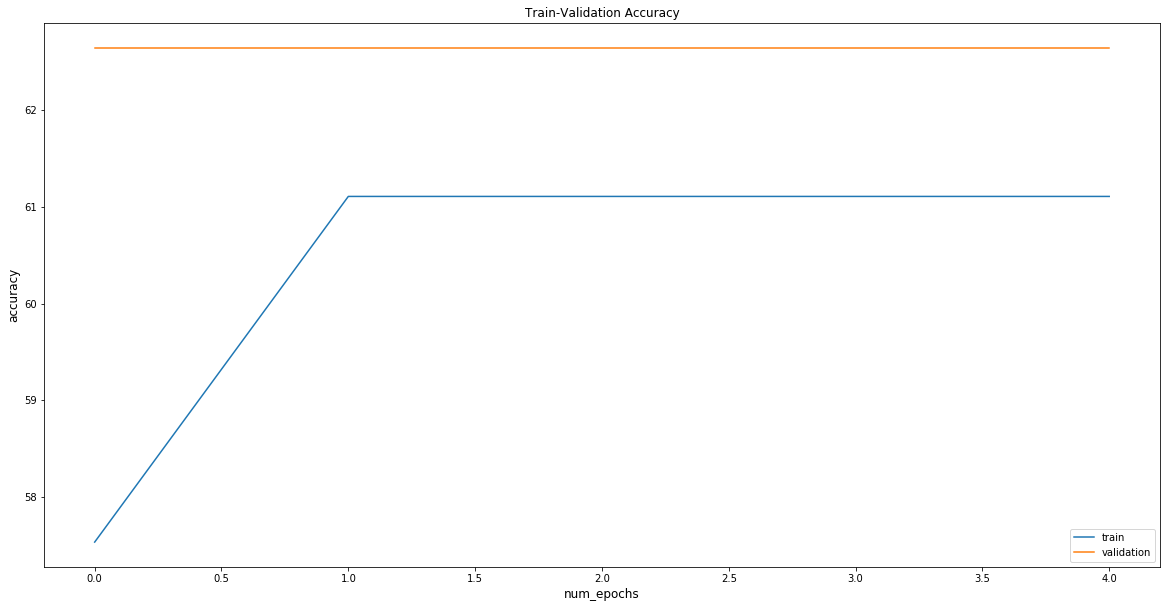

In [8]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')